# Run IDF

In [10]:
import sys
from pathlib import Path

# Find the nearest directory that has a "src" folder (works no matter where you run the notebook)
here = Path.cwd()
src_dir = next(p for p in [here, *here.parents] if (p / "src").exists()) / "src"
sys.path.insert(0, str(src_dir))

In [ ]:
from tqdm import tqdm
# from ReIDF import run_IDF

# idf_files = ['../_base/idf/HVACDetailed-Jul.idf']
idf_files = ['ref/HVACDetailed-Jul.idf']
weather_file = '../_base/epw/ED-TMYx.2023.epw'
energyplus_exe = 'C:/EnergyPlusV23-2-0/EnergyPlus'

output_folders = []
for idf_file in tqdm(idf_files, desc="E+ running", unit=".idf file"):
    output_folder = run_IDF(idf_file, weather_file, energyplus_exe=energyplus_exe)
    output_folders.append(output_folder)

E+ running:   0%|          | 0/1 [00:00<?, ?.idf file/s]

# Plot HeatBalance
https://unmethours.com/question/20720/energy-plus-calculate-zone-energy-balance-manually/

# Validation
2029.477185	1790.84028	0	-20222.56028	0	16410.03146	4.99013263


In [2]:
%matplotlib inline
import pandas as pd
from __pltReIDF import (
    load_long, compute_aggs, get_df, plot_heat_balance,
    build_zone_meta_from_csvs)
areas = None  # optional
eplusout_path= "../_base/idf/HVACDetailed-Jul/eplusout.csv"

zone_meta, _ = build_zone_meta_from_csvs(
    summary_csv="ref/zones_by_floor_summary.csv",
    areas_csv="ref/zone_areas.csv",
    mode="primary"   # or "primary"
)
long_df = load_long(eplusout_path, assume_year=2021, zone_meta_df=zone_meta)
aggs = compute_aggs(long_df)

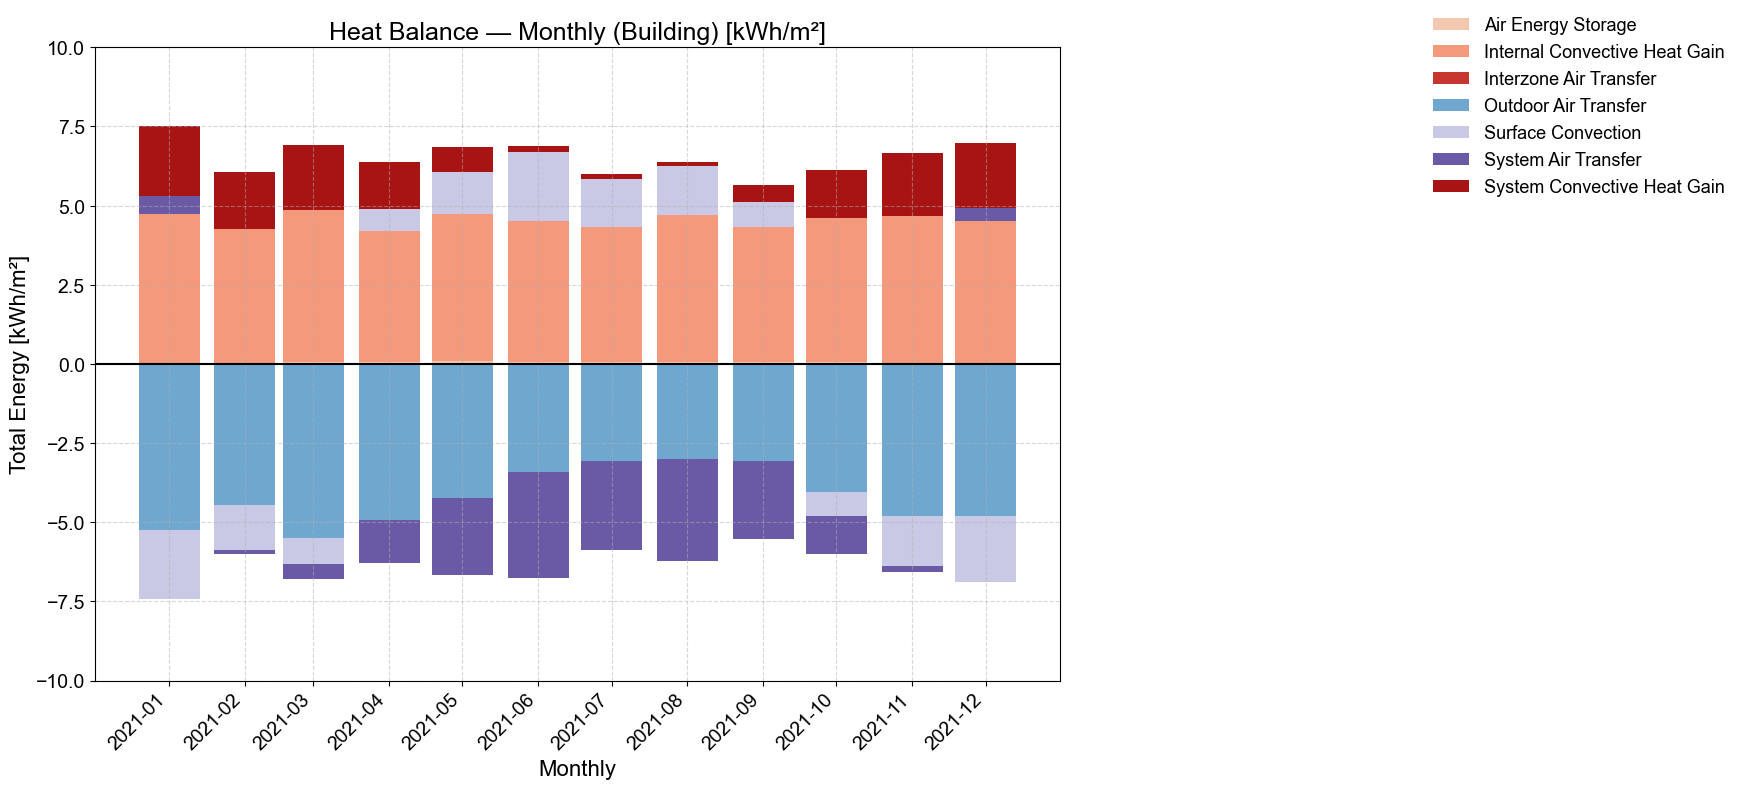

In [2]:
# use hex or RGBA tuples; keys MUST match your cleaned legend labels
USER_COLORS = {
    "Air Energy Storage":            "#f3c7b0",
    "Internal Convective Heat Gain": "#f5997d",
    "Interzone Air Transfer":        "#c7362f",
    "Outdoor Air Transfer":          "#6fa7cf",
    "Surface Convection":            "#c9c9e6",
    "System Air Transfer":           "#6a5aa6",
    "System Convective Heat Gain":   "#a81414",
}


df_bldg = get_df(aggs, scale="monthly", scope="building",
                 units="kWh", per_m2=True, long_df_for_area=long_df)

plot_heat_balance(df_bldg, scale="monthly", scope="building",
                  units="kWh", per_m2=True,
                  fixed_color_map=USER_COLORS, strict_colors=True)


In [9]:
df_bldg = get_df(aggs, scale="yearly", scope="building", units="kWh", per_m2=True, long_df_for_area=long_df)
df_bldg

,Year,Variable,Value,Value_per_m2
0,2021,Zone Air Heat Balance Air Energy Storage Rate ...,6387.325654,0.665362
1,2021,Zone Air Heat Balance Internal Convective Heat...,516979.035364,53.853217
2,2021,Zone Air Heat Balance Interzone Air Transfer R...,0.000000,0.000000
3,2021,Zone Air Heat Balance Outdoor Air Transfer Rat...,-485315.824052,-50.554890
4,2021,Zone Air Heat Balance Surface Convection Rate ...,-8138.735455,-0.847804
5,2021,Zone Air Heat Balance System Air Transfer Rate...,-159551.807451,-16.620361
6,2021,Zone Air Heat Balance System Convective Heat G...,142758.457491,14.871013


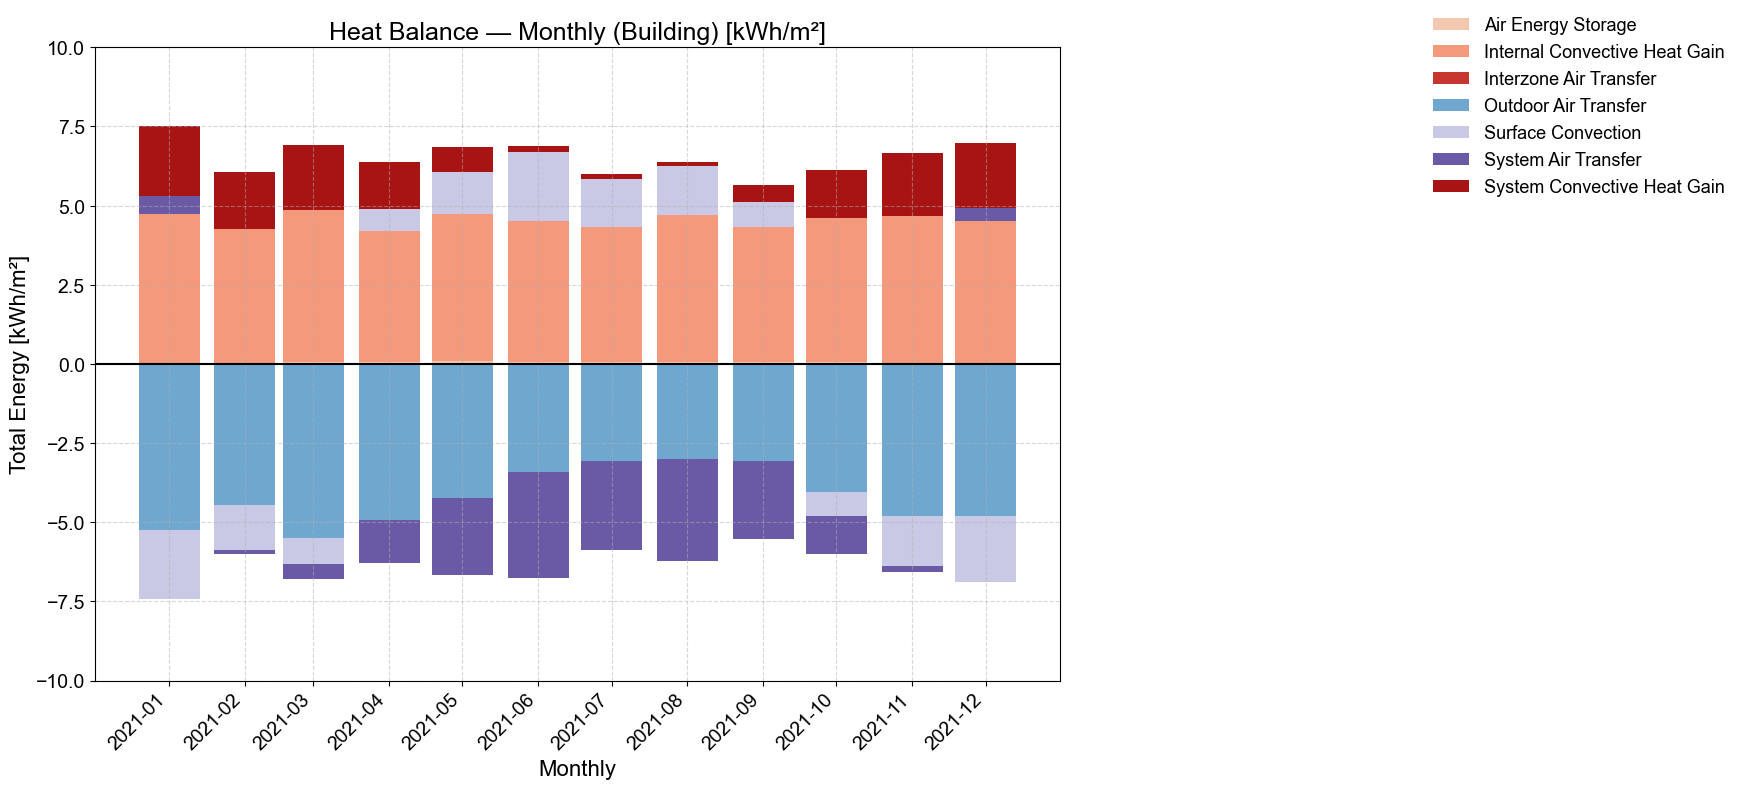

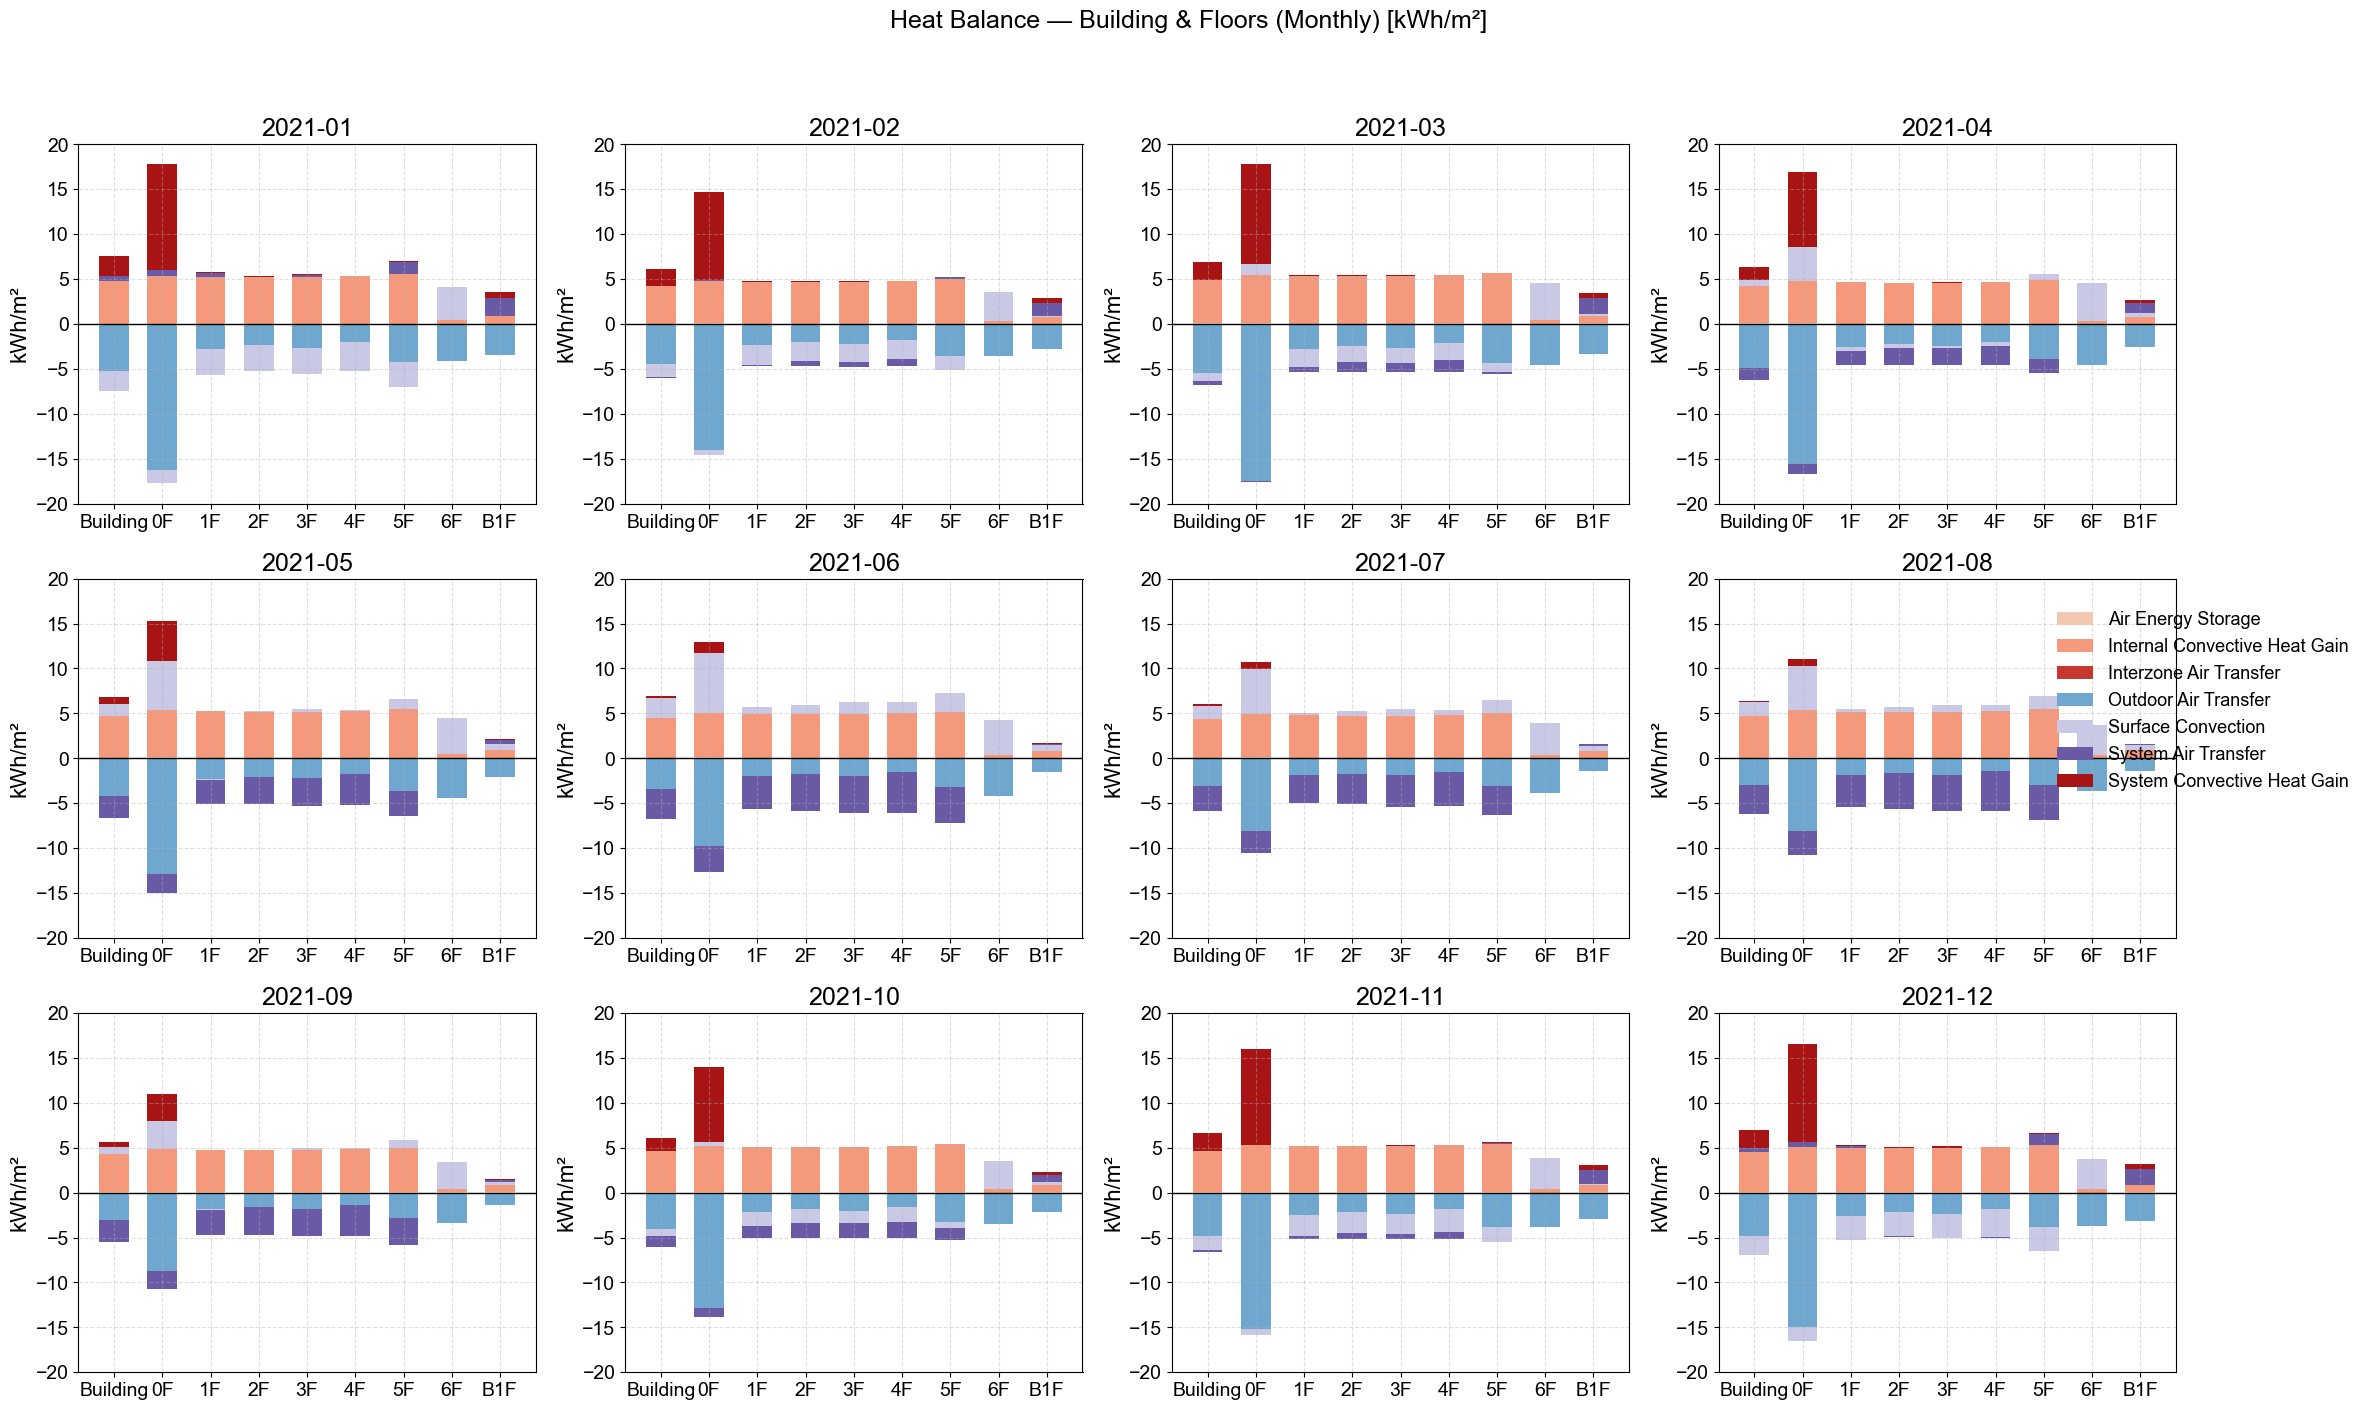

In [3]:
# Your fixed colors (cleaned names)
from __pltReIDF import plot_month_compare_across_building_and_floors


USER_COLORS = {
    "Air Energy Storage": "#f3c7b0",
    "Internal Convective Heat Gain": "#f5997d",
    "Interzone Air Transfer": "#c7362f",
    "Outdoor Air Transfer": "#6fa7cf",
    "Surface Convection": "#c9c9e6",
    "System Air Transfer": "#6a5aa6",
    "System Convective Heat Gain": "#a81414",
}

# Building-only (unchanged)
df_bldg = get_df(aggs, scale="monthly", scope="building",
                 units="kWh", per_m2=True, long_df_for_area=long_df)
plot_heat_balance(df_bldg, scale="monthly", scope="building",
                  units="kWh", per_m2=True,
                  fixed_color_map=USER_COLORS, strict_colors=True)

# Building vs floors, months grid — with 1F, 2F, … and B1F for -1
plot_month_compare_across_building_and_floors(
    aggs=aggs,
    long_df=long_df,
    floors=list(range(-1, 7)),
    units="kWh",
    per_m2=True,
    fixed_color_map=USER_COLORS,
    strict_colors=True,
    floor_labeler=lambda f: (f"{int(f)}F" if int(f) >= 0 else f"B{abs(int(f))}F")
)


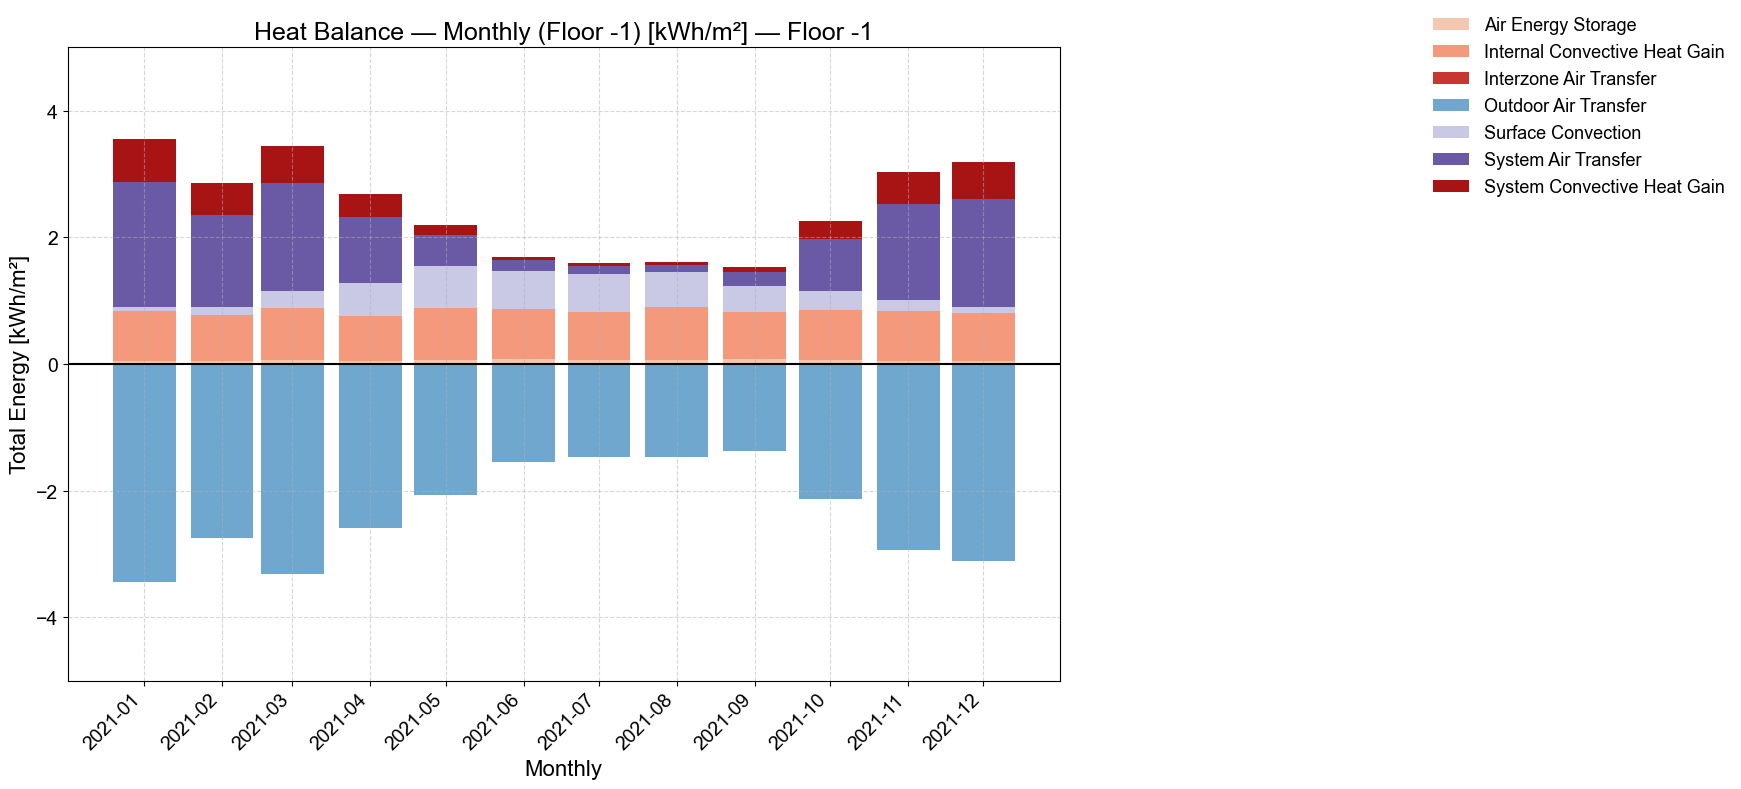

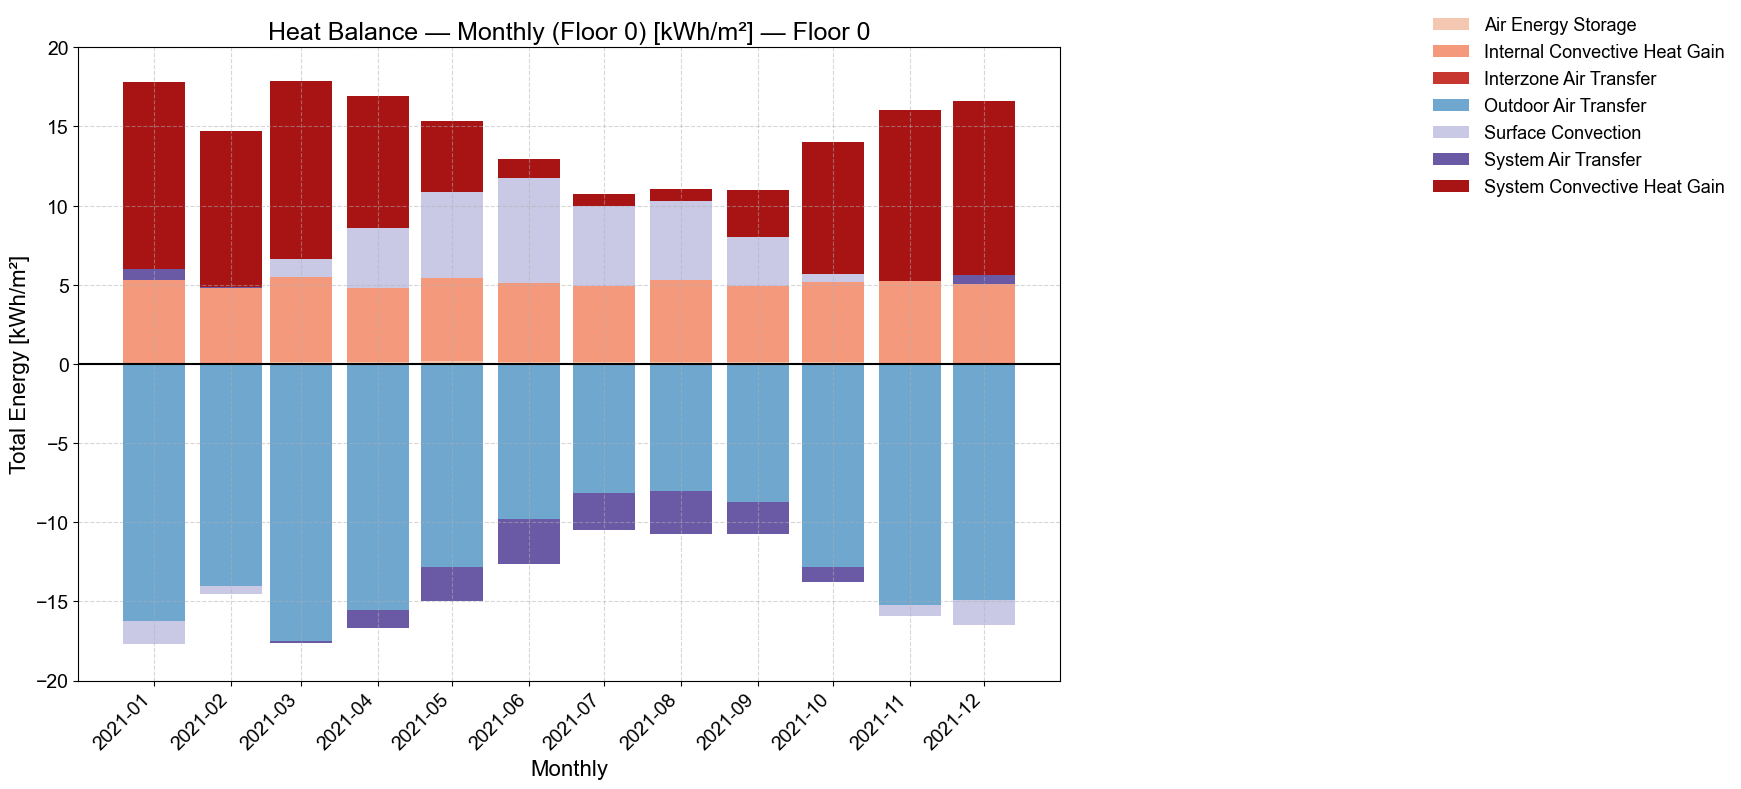

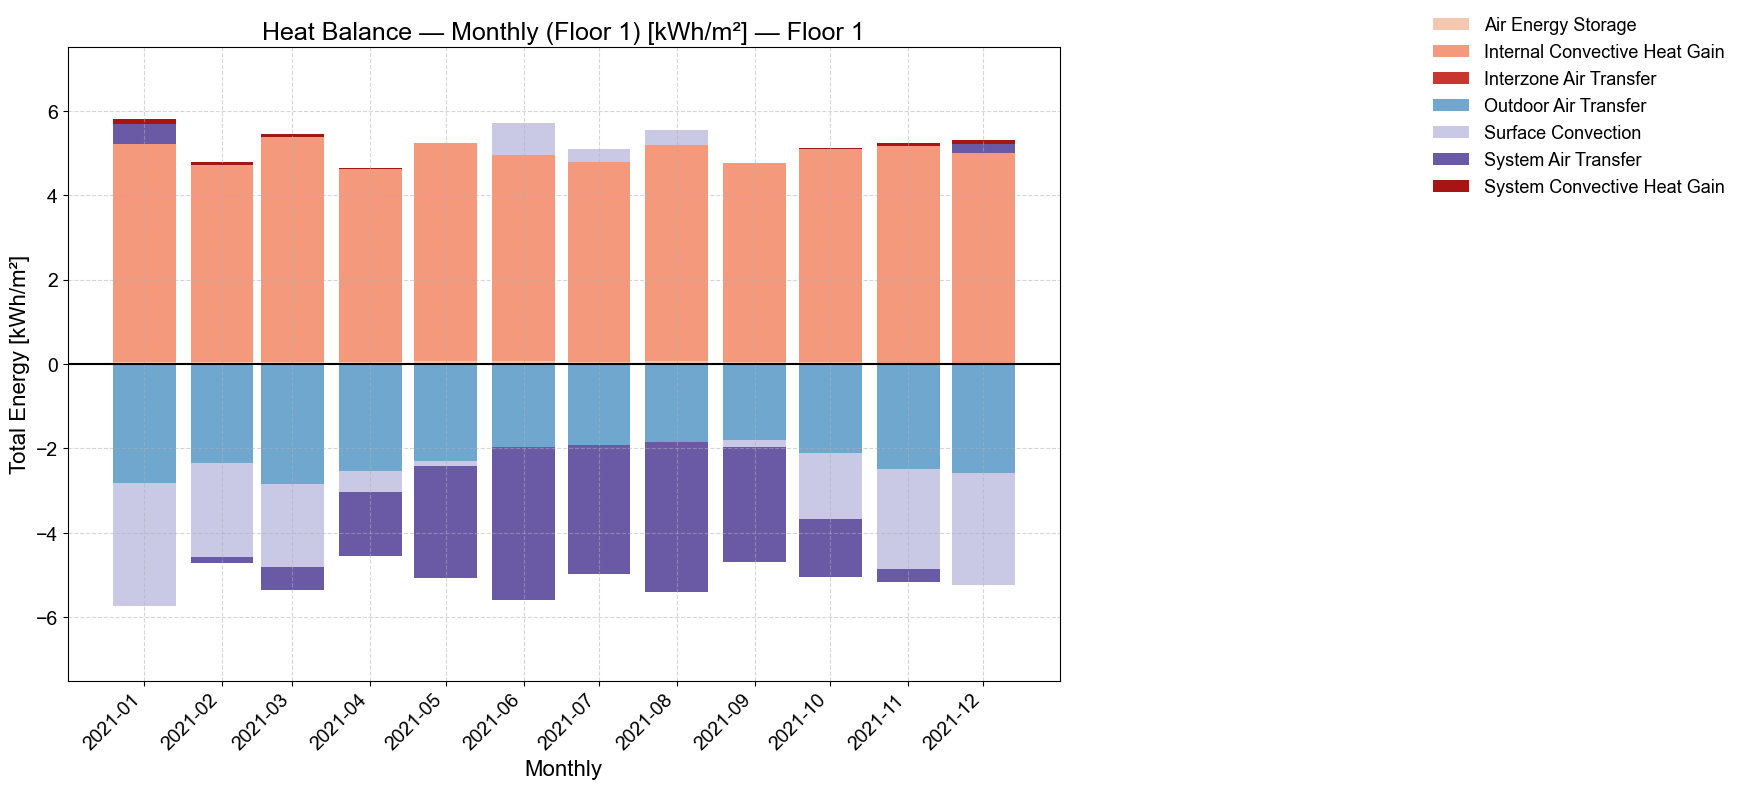

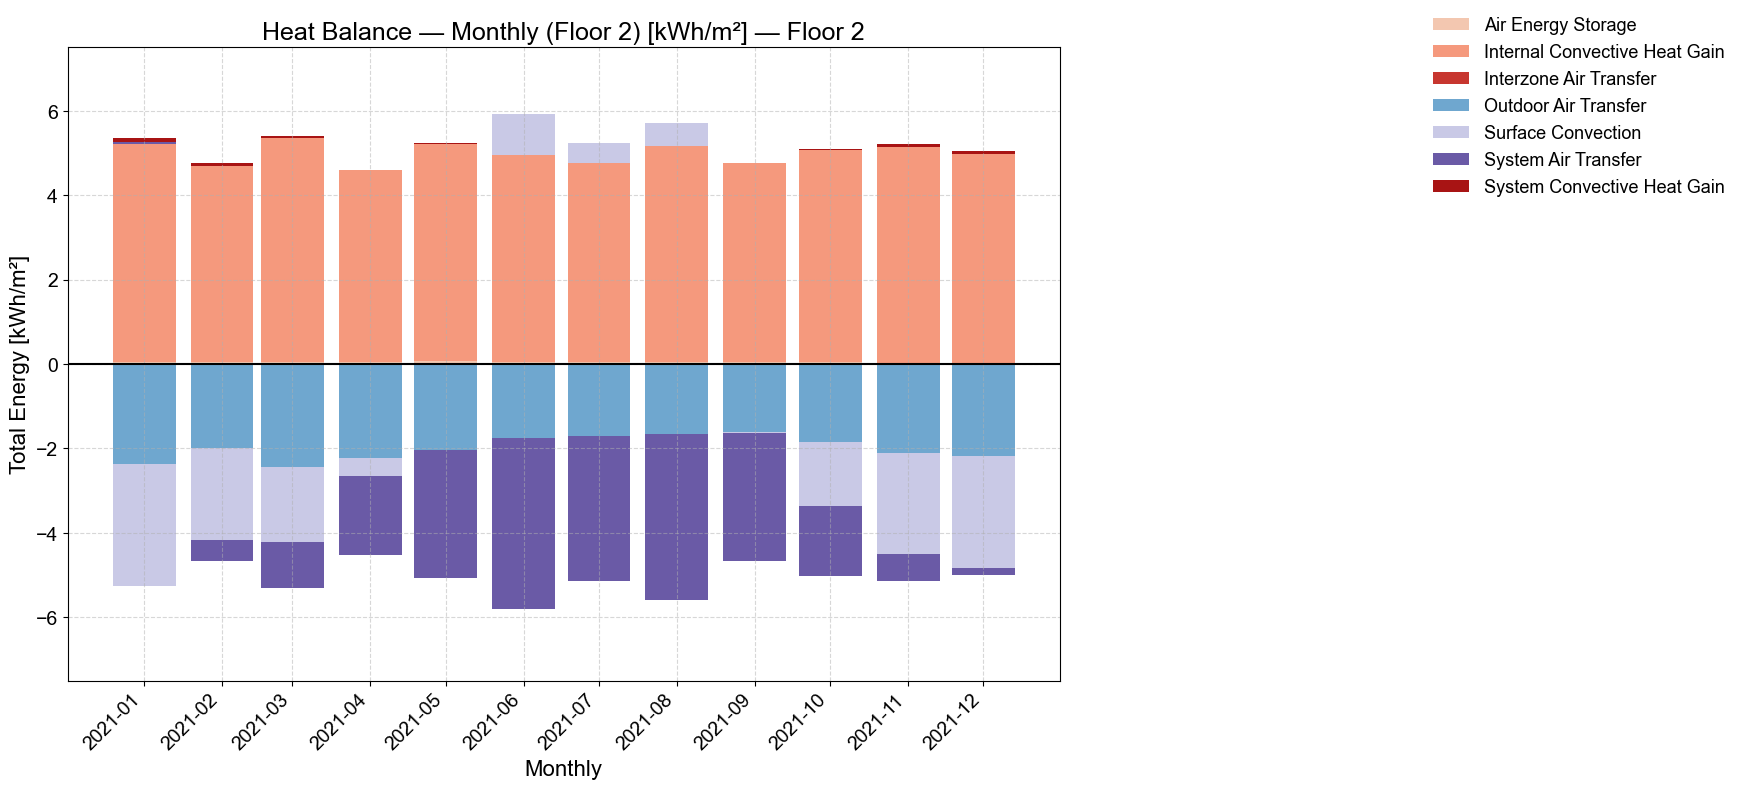

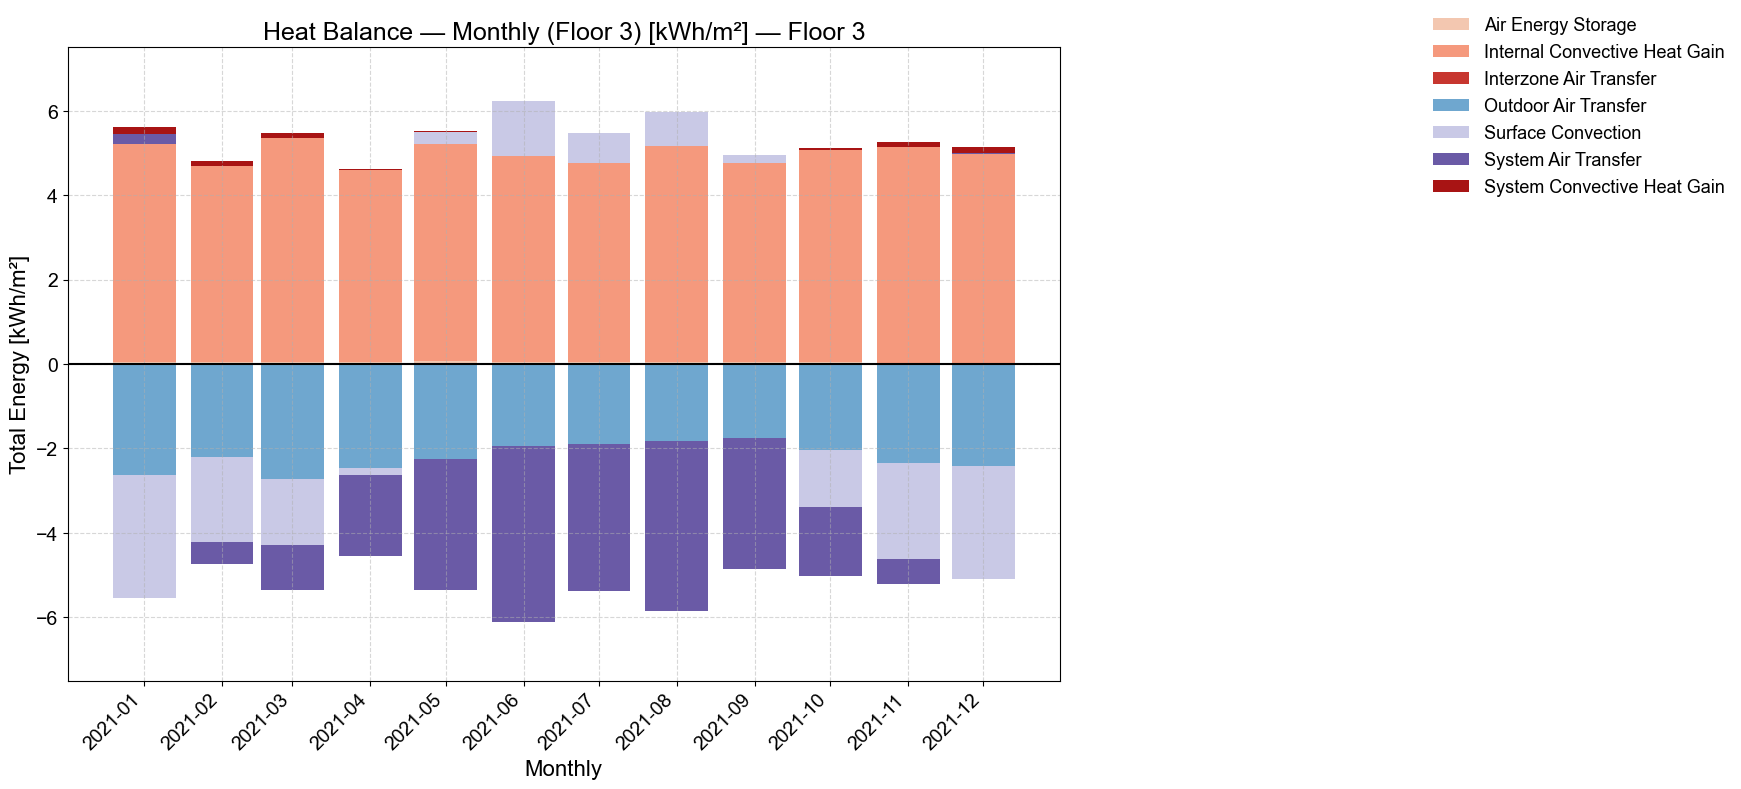

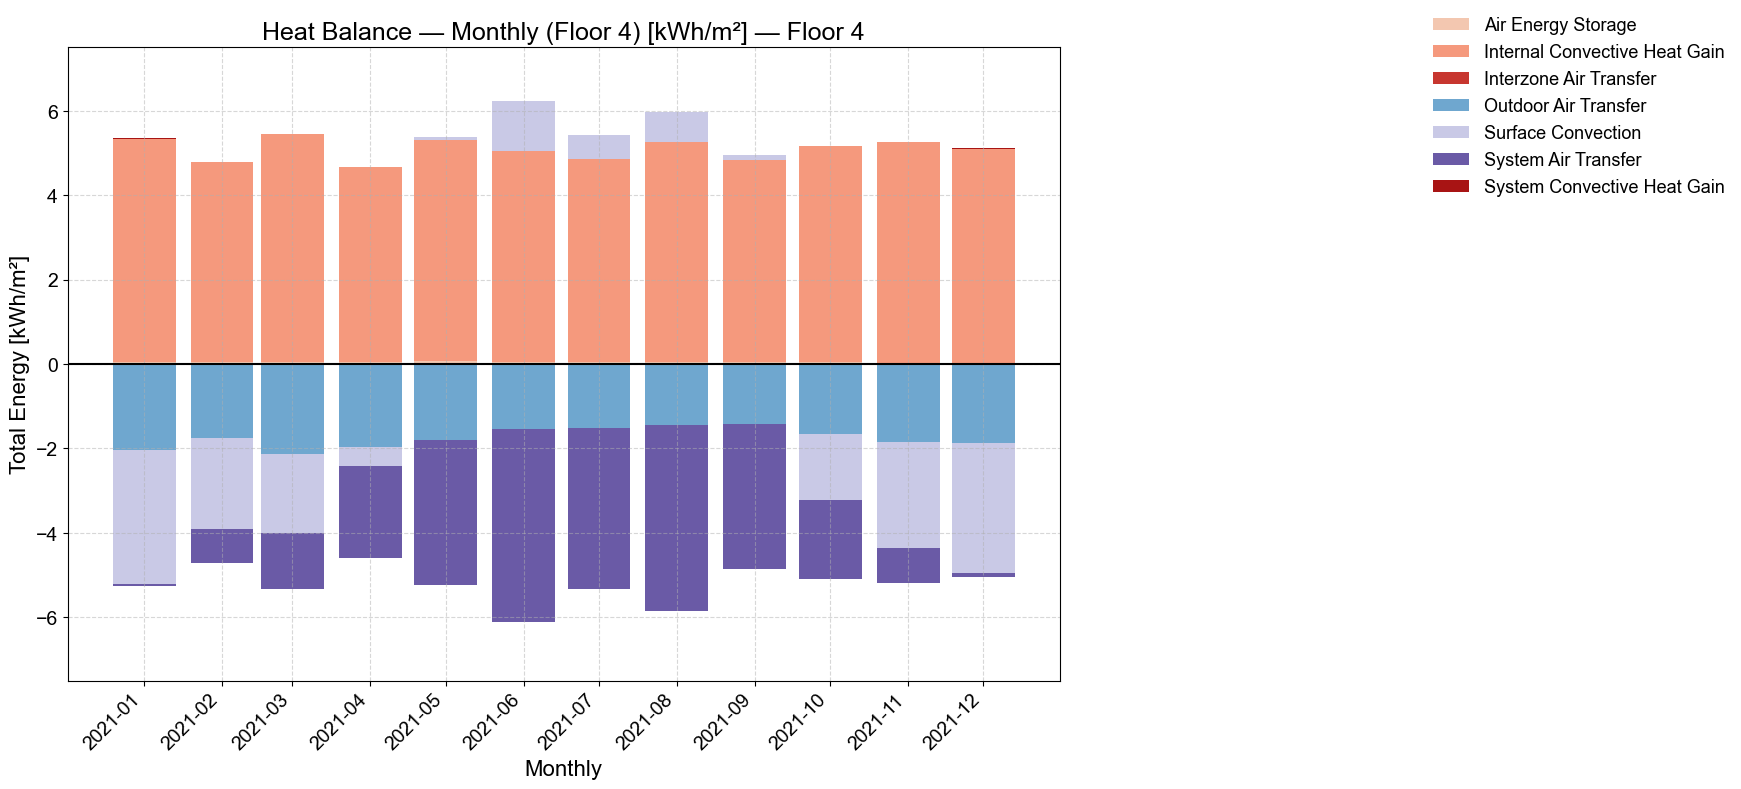

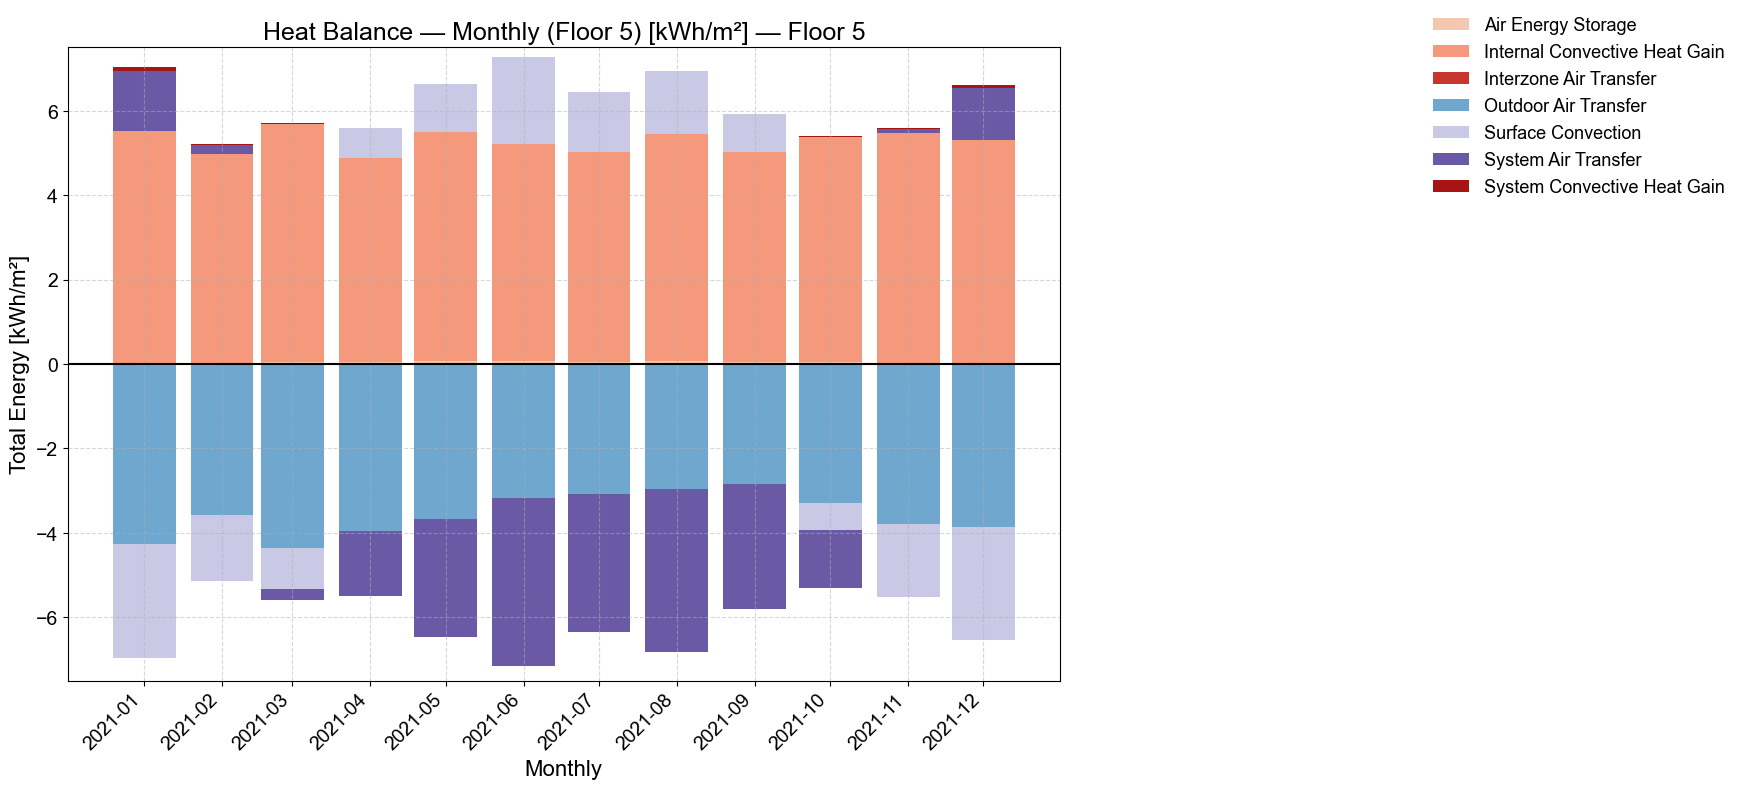

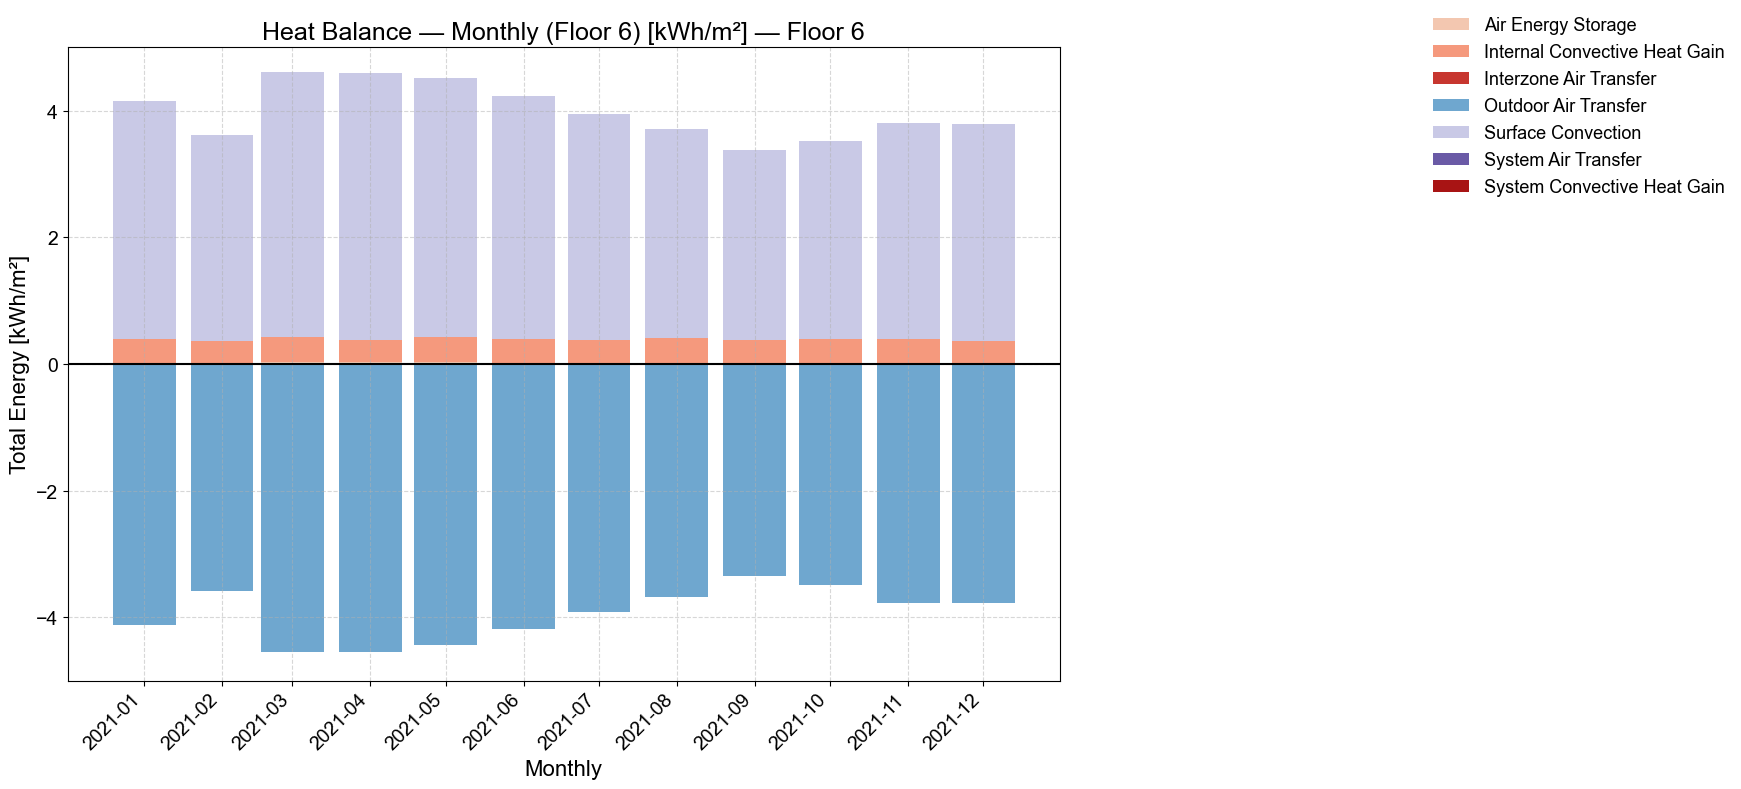

In [4]:
# Floors -1..6 (same colors)
for f in range(-1, 7):
    df_f = get_df(aggs, scale="monthly", scope="floor", floor=f,
                  units="kWh", per_m2=True, long_df_for_area=long_df)
    if df_f.empty:
        print(f"[Info] Floor {f} has no data.")
        continue
    plot_heat_balance(df_f, scale="monthly", scope=f"floor {f}",
                      units="kWh", per_m2=True, fixed_color_map=USER_COLORS, strict_colors=True,
                      title_suffix=f"— Floor {f}")